### Consumer Complaints Dataset Analysis

### The objective is to build a classification model which can predict whether the consumer’s complaint will be upheld and whether they are likely to receive financial relief, given the financial product they purchased, the company providing that product, and the nature of the complaint as described by the consumer. Upholding the complaint means that the costumer gets compensated either monetarily or non-monetarily. 

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('Consumer_Complaints.csv')

In [2]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


In [3]:
#Let's examine the number of missing data for each feature
df.isna().sum()

Date received                        0
Product                              0
Sub-product                     235160
Issue                                0
Sub-issue                       477597
Consumer complaint narrative    704013
Company public response         646002
Company                              0
State                             9225
ZIP code                          9278
Tags                            777945
Consumer consent provided?      528549
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?              135408
Complaint ID                         0
dtype: int64

In [4]:
#Picking the features that are mentioned in the objective
alldata = df[['Product', 'Sub-product', 'Company', 'Consumer complaint narrative', 'Company response to consumer']]
data = alldata.dropna(axis=0, subset=['Consumer complaint narrative']).reset_index().drop(['index'], axis=1)

In [5]:
#Check the distribution of the possible company responses
data['Company response to consumer'].value_counts()

Closed with explanation            158554
Closed with non-monetary relief     22951
Closed with monetary relief         13133
Closed                               3742
Untimely response                    1589
In progress                             1
Name: Company response to consumer, dtype: int64

In [6]:
#Sub-product is still missing in some rows, but that's fine, missing value can still be used for classification
data.isna().sum()

Product                             0
Sub-product                     52182
Company                             0
Consumer complaint narrative        0
Company response to consumer        0
dtype: int64

In [7]:
#Let's remove 'In Progress', since we don't know the outcome yet
mask = data['Company response to consumer'] == 'In progress'
data = data.loc[~mask,:]

In [8]:
#Label is 1, if the complaint is upheld
data['label'] = data['Company response to consumer'].isin(['Closed with non-monetary relief', 'Closed with monetary relief', 'Closed with relief']).astype('int')

In [9]:
#Unbalanced classes, only about 18% is positive (complaint upheld)
sum(data['label']) / len(data)

0.18044796943526248

## Bar plots with covariates of interests

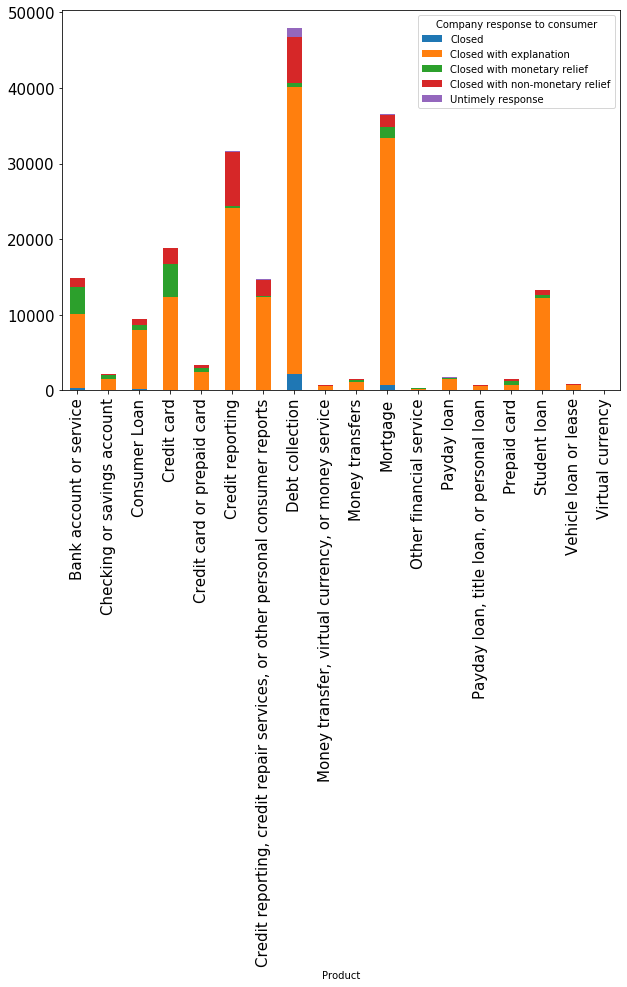

In [10]:
data[['Product', 'Company response to consumer', 'label']].groupby(['Product', 'Company response to consumer']).count().reset_index().pivot(index = 'Product', columns='Company response to consumer', values='label').plot.bar(figsize = (10,7), fontsize = 15, stacked=True)

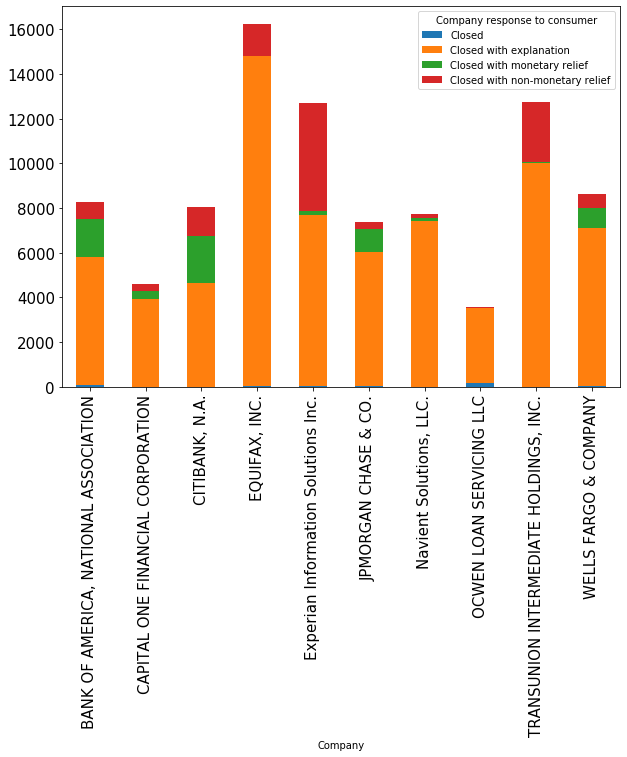

In [11]:
mask = data.Company.isin(data.Company.value_counts()[:10].index.to_list())
bigCompany = data.loc[mask,:]
bigCompany[['Company', 'Company response to consumer', 'label']].groupby(['Company', 'Company response to consumer']).count().reset_index().pivot(index = 'Company', columns='Company response to consumer', values='label').plot.bar(figsize = (10,7), fontsize = 15, stacked=True)

### We don't want the model to focus on the actual number the complaint is for; surely if the complaint is legitimate, the money is refunded, regardless of the actual amount. Also, we don't want to confuse the model with different numbers, hence we will simply use 'amount' whenever a Dollar amount is encountered in the text within curly brackets

In [12]:
#We don't want the model to focus on the actual number the complaint is for; surely if the complaint is legitimate, 
#the money is refunded, regardless of the actual amount

import re #all numbers are in {}
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(lambda row: re.sub(r'\{.*?\}', 'amount', row))

In [13]:
#Drop the outcome from the feature set, no cheating 
X = data.drop(['label'], axis=1)
y = data['label']

In [14]:
#Creating a new text field, that's a concatenation of other text fields; will be used in deep learning
X['Concat'] = X[['Company', 'Product', 'Sub-product', 'Consumer complaint narrative']].astype('str').agg(' '.join, axis=1)

In [15]:
X['Concat'].iloc[0]

'TRANSUNION INTERMEDIATE HOLDINGS, INC. Credit reporting nan I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements'

In [16]:
#For the gradient boosting model, we label encode the categorical features
from sklearn.preprocessing import LabelEncoder
X["Product"] = LabelEncoder().fit_transform( X.Product )
X["Company"] = LabelEncoder().fit_transform( X.Company )

X["Sub-product"] = X['Sub-product'].fillna('0')
X["Sub-product"] = LabelEncoder().fit_transform( X['Sub-product'] )

In [17]:
#Since we have a lot of samples, let's do a simple holdout cross-validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26, stratify=data['label'])

In [18]:
#From https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          fontsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    g = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, annot_kws=({"fontsize":fontsize}))
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize=fontsize)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize=fontsize)

    if xyplotlabels:
        plt.ylabel('True label', fontsize=fontsize)
        plt.xlabel('Predicted label' + stats_text, fontsize=fontsize)
    else:
        plt.xlabel(stats_text, fontsize=fontsize)
    
    if title:
        plt.title(title, fontsize=round(fontsize*1.5))

# First model: TFIDF

<iframe src="https://www.kaggle.com/embed/chandra03/multi-class-text-classification-tfidf?cellId=26&cellIds=26&kernelSessionId=33706057" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Multi-class text classification (TFIDF)"></iframe>

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
#only care about words or 2-grams that appear in less than 80% of the samples
#Take the top words/2-grams ordered by term frequency across the corpus.
vectorizer = TfidfVectorizer(decode_error='ignore', max_features = 1000, max_df = 0.8, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train['Consumer complaint narrative'])

In [25]:
#The result is a compressed sparse matrix
X_train_tfidf

<159975x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 14180609 stored elements in Compressed Sparse Row format>

In [27]:
#We can easily check for the words/2-grams that were taken into consideration
vectorizer.get_feature_names()[100:110]

['asked',
 'asked for',
 'asking',
 'assistance',
 'at',
 'at the',
 'at this',
 'at xxxx',
 'attached',
 'attempt']

In [28]:
#Here we see the LabelEncoding in action
X_train[['Product', 'Sub-product', 'Company']]

,Product,Sub-product,Company
140138,10,10,1343
9508,3,1,529
7067,0,8,3218
23592,7,48,2576
162972,10,20,2062
...,...,...,...
51219,0,8,2740
103758,3,1,392
99557,0,8,573
164691,0,49,3218


In [46]:
#Let's merge the encoded categorical features with the TFIDF scores of the consumer complaint to get our training set
train = pd.concat([X_train[['Product', 'Sub-product', 'Company']].reset_index().drop(['index'], axis=1), pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns = vectorizer.get_feature_names())], axis=1)

In [32]:
X_test_tfidf = vectorizer.transform(X_test['Consumer complaint narrative'])

In [52]:
test = pd.concat([X_test[['Product', 'Sub-product', 'Company']].reset_index().drop(['index'], axis=1), pd.DataFrame.sparse.from_spmatrix(X_test_tfidf, columns = vectorizer.get_feature_names())], axis=1)

In [185]:
#Let's train and evaluate using XGBClassifier
from xgboost import XGBClassifier

model = XGBClassifier(
    colsample_bytree=0.8, 
    subsample=0.8, 
    #tree_method='gpu_hist',
    gpu_id=0)

model.fit(
    train, 
    y_train, 
    eval_metric="error", 
    eval_set=[(train, y_train),
              (test, y_test)], 
    verbose=True)

C:\Users\sarva\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-error:0.17105	validation_1-error:0.17358
[1]	validation_0-error:0.16983	validation_1-error:0.17198
[2]	validation_0-error:0.16943	validation_1-error:0.17210
[3]	validation_0-error:0.16827	validation_1-error:0.17098
[4]	validation_0-error:0.16778	validation_1-error:0.17103
[5]	validation_0-error:0.16758	validation_1-error:0.17088
[6]	validation_0-error:0.16706	validation_1-error:0.17083
[7]	validation_0-error:0.16639	validation_1-error:0.17060
[8]	validation_0-error:0.16596	validation_1-error:0.17050
[9]	validation_0-error:0.16585	validation_1-error:0.17003
[10]	validation_0-error:0.16543	validation_1-error:0.17035
[11]	validation_0-error:0.16538	validation_1-error:0.16997
[12]	validation_0-error:0.16491	validation_1-error:0.16970
[13]	validation_0-error:0.16409	validation_1-error:0.16925
[14]	validation_0-error:0.16326	validation_1-error:0.16900
[15]	validation_0-error:0.16291	validation_1-error:0.16875
[16]	validation_0-error:0.16251	validation_1-error:0.16825
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [186]:
preds = model.predict(test)

In [187]:
#Let's check out the F1-score that's a better evaluation than accuracy in unbalanced binary classification
f1_score(y_test, preds>0.5)

0.30727650727650735

In [188]:
#Matthew's correlation coefficient
matthews_corrcoef(y_test, preds>0.5)

0.28573864630159335

In [58]:
#Plot XGBoost feature importance
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

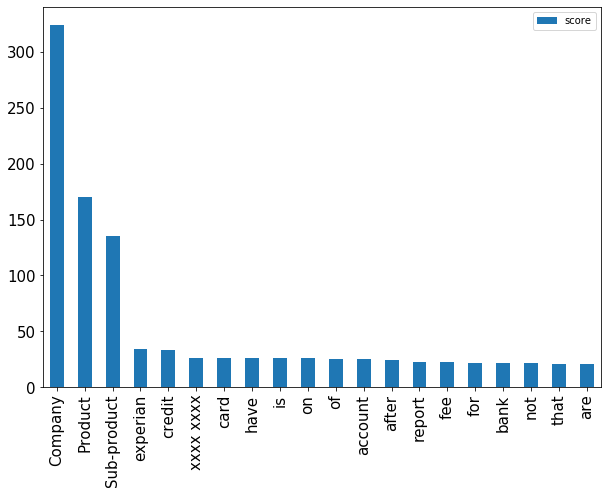

In [66]:
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.iloc[:20,:].plot(kind='bar', figsize = (10,7), fontsize = 15)

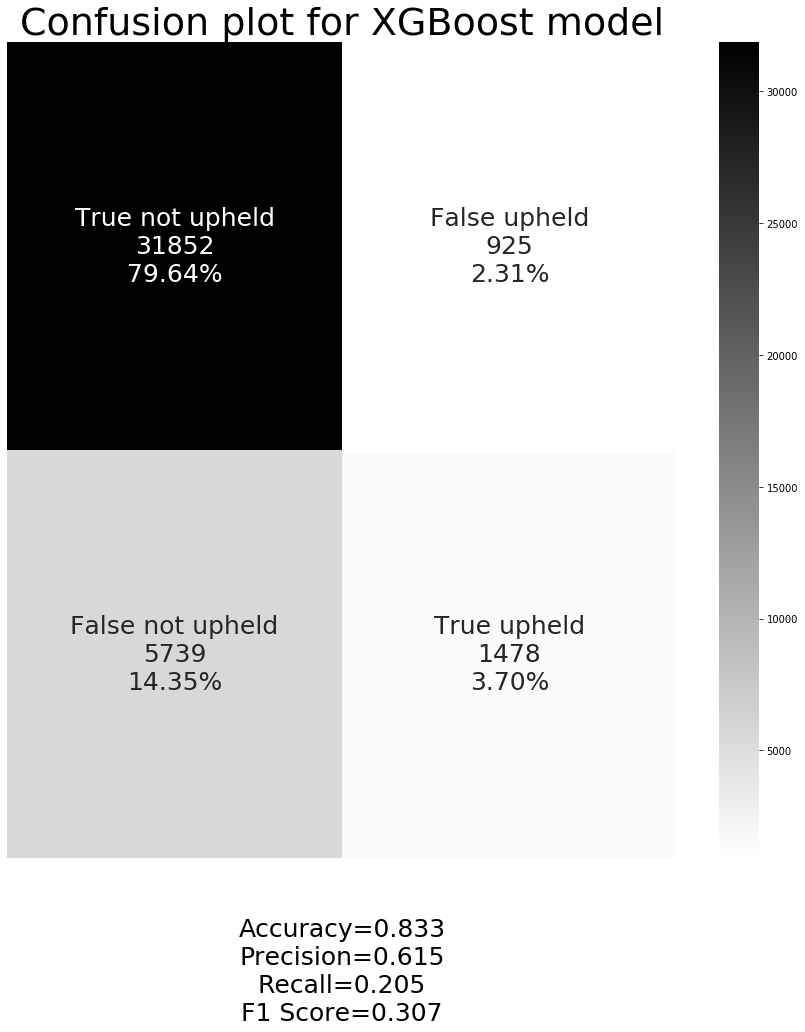

In [189]:
#Create the confusion matrix in a nice plot
cm = confusion_matrix(y_test, preds>0.5)
labels = ['True not upheld', 'False upheld', 'False not upheld', 'True upheld']
categories = ['Not upheld, Upheld']
make_confusion_matrix(np.array(cm, dtype='float'),
                      group_names=labels,
                      categories=categories,
                      xyticks=False,
                      xyplotlabels=False,
                      cmap='binary',
                      figsize=(15,15),
                      fontsize=25,
                      title='Confusion plot for XGBoost model')

# Deep learning

## We try ResidualNets, LSTM, LSTM/Convolutional neural network combination and pretrained state-of-the-art BERT model

In [75]:
#Setting GPU usage on tensorflow
#Using half-precision to speed-up computation and take advantage of RTX architecture (using NVIDIA RTX 2070 Super)

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [78]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_dim = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [120]:
X_train

,Product,Sub-product,Company,Consumer complaint narrative,Company response to consumer,Concat
140138,10,10,1343,I was charged late fees by my mortgage company...,Closed with explanation,GUARANTEED RATE INC. Mortgage Conventional fix...
9508,3,1,529,Aproximately 4 weeks ago Capital One placed a ...,Closed with explanation,CAPITAL ONE FINANCIAL CORPORATION Credit card ...
7067,0,8,3218,"Over the past couple of years, Wells Fargo has...",Closed with explanation,WELLS FARGO & COMPANY Bank account or service ...
23592,7,48,2576,I called the debt collector several times to h...,Untimely response,"Rent Recover, LLC Debt collection Other (i.e. ..."
162972,10,20,2062,"NATIONSTAR IS GUILTY OF RACKETEERING, EXTORTIO...",Closed with explanation,NATIONSTAR MORTGAGE Mortgage FHA mortgage NATI...
...,...,...,...,...,...,...
51219,0,8,2740,I received a phone call at XXXX from XXXX at X...,Closed with explanation,SYNCHRONY FINANCIAL Bank account or service Ch...
103758,3,1,392,THERE WAS A PROMOTION FROM BARCLAY BANK FOR CR...,Closed with explanation,BARCLAYS BANK DELAWARE Credit card nan THERE W...
99557,0,8,573,I opened my citigold checking account on XXXX/...,Closed with explanation,"CITIBANK, N.A. Bank account or service Checkin..."
164691,0,49,3218,My ex-husband opened an account for our XXXX c...,Closed with explanation,WELLS FARGO & COMPANY Bank account or service ...


In [121]:
#Convert words into tokens (numbers) using tokenizer
tokenizer = Tokenizer(oov_token = oov_tok)
tokenizer.fit_on_texts(X_train['Concat'].values)
word_index = tokenizer.word_index
vocab_size = len(word_index)

train_sequences = tokenizer.texts_to_sequences(X_train['Concat'].values)
test_sequences = tokenizer.texts_to_sequences(X_test['Concat'].values)

(array([1.8086e+04, 3.5621e+04, 2.8788e+04, 2.0660e+04, 1.4486e+04,
        1.0094e+04, 7.5580e+03, 5.5040e+03, 4.1360e+03, 3.1400e+03,
        2.4600e+03, 2.0910e+03, 2.0870e+03, 2.2360e+03, 1.8120e+03,
        5.8400e+02, 1.3000e+02, 7.6000e+01, 6.0000e+01, 4.7000e+01,
        3.5000e+01, 2.7000e+01, 2.8000e+01, 3.1000e+01, 2.0000e+01,
        1.7000e+01, 1.4000e+01, 1.6000e+01, 9.0000e+00]),
 array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
         550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
        1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450]),
 <a list of 29 Patch objects>)

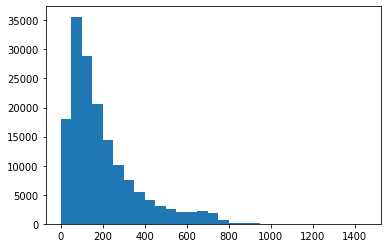

In [122]:
#Plotting the distribution of sequence lengths
plt.hist([len(seq) for seq in train_sequences], bins = range(0, 1500, 50))

In [133]:
#Based on the above plot, let's choose 512 as the maximum sequence length and we pad shorter sequences 
max_length = 512
padded_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [134]:
#We have 159975 training samples
padded_train.shape

(159975, 512)

In [126]:
#Let's encode the tokens to actual Glove Embeddings using the word_index that the tokenizer built and the glove.6B.100d.txt
#document that contains the embeddings
embeddings_index = {};
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float16');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [184]:
#This is our first deep learning model, a version of ResNet - result is inferior to that of XGBoost
def residual_block(x, filters):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, padding="same")(a1)
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

inputs = tf.keras.Input(shape=(max_length,))
x = tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)(inputs)
x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = residual_block(x, 64)
x = tf.keras.layers.Permute(dims=[2, 1])(x)
x = tf.keras.layers.Conv1D(64, 32, padding="same")(x) #modified to 32, with 3 result was slightly better
#x = tf.keras.layers.Dropout(0.2)(x)
x = residual_block(x, 64)
x = tf.keras.layers.Permute(dims=[2, 1])(x)
x = tf.keras.layers.MaxPooling1D(64)(x)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

num_epochs = 5

history = model.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_test, y_test), verbose=2)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 512, 100)     7924300     input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 512, 64)      19264       embedding_32[0][0]               
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 512, 64)      256         conv1d_43[0][0]                  
___________________________________________________________________________________________

In [150]:
#The second deep-learning model we try: LSTM Model. It outperforms all other models. 
LSTMModel = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
LSTMModel.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
LSTMModel.summary()

history = LSTMModel.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_test, y_test), verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 512, 100)          7924300   
_________________________________________________________________
lstm (LSTM)                  (None, 512, 64)           42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 7,971,741
Trainable params: 47,441
Non-trainable params: 7,924,300
_________________________________________________________________
Epoch 1/5
5000/5000 - 318s - loss: 0.4729 - accuracy: 0.8196 - val_loss: 0.4721 - val_accuracy: 0.8195
Epoch 2/5
5000/5000 - 322s - loss: 0.4612 - accuracy: 0.8194 - val_loss: 0.4557 - val_accuracy: 0.8195
Epoch 3/5
5000/5000 - 321s - loss

In [152]:
history = LSTMModel.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_test, y_test), verbose=2)

Epoch 1/5
5000/5000 - 322s - loss: 0.3655 - accuracy: 0.8354 - val_loss: 0.3690 - val_accuracy: 0.8364
Epoch 2/5
5000/5000 - 316s - loss: 0.3608 - accuracy: 0.8375 - val_loss: 0.3654 - val_accuracy: 0.8378
Epoch 3/5
5000/5000 - 312s - loss: 0.3559 - accuracy: 0.8400 - val_loss: 0.3643 - val_accuracy: 0.8378
Epoch 4/5
5000/5000 - 320s - loss: 0.3513 - accuracy: 0.8413 - val_loss: 0.3645 - val_accuracy: 0.8371
Epoch 5/5
5000/5000 - 324s - loss: 0.3470 - accuracy: 0.8436 - val_loss: 0.3603 - val_accuracy: 0.8402


In [156]:
preds = LSTMModel.predict(padded_test)

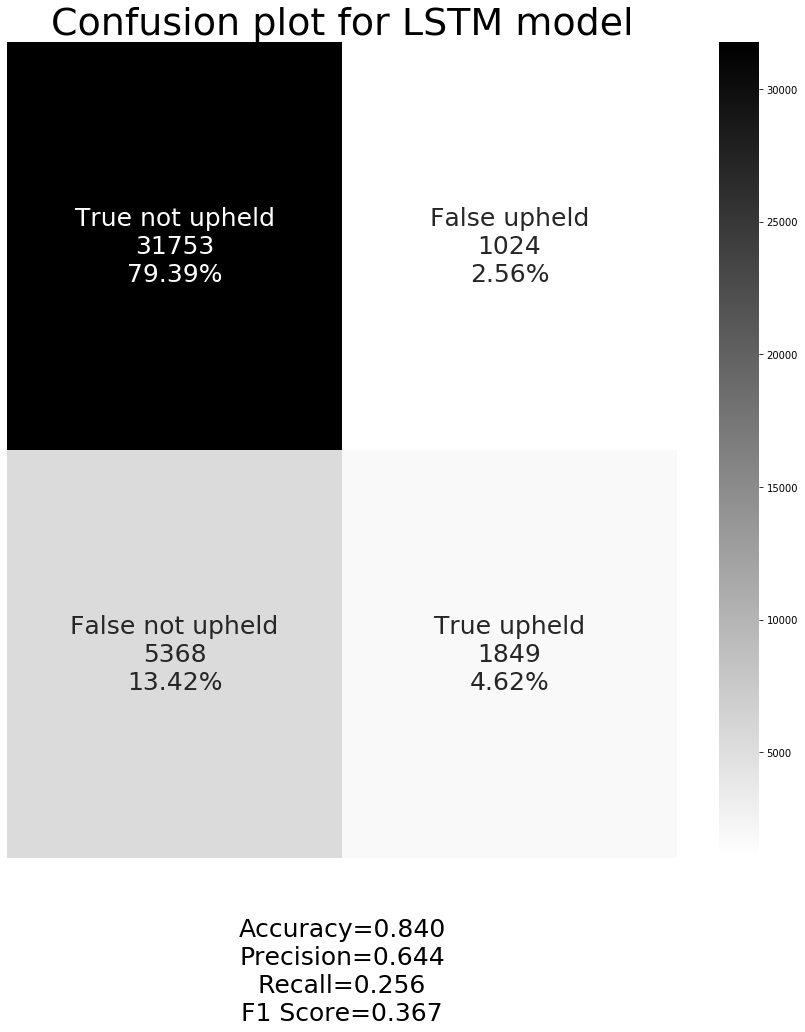

In [160]:
#Best prediction result plot, achieved by the LSTM Model
cm = confusion_matrix(y_test, preds>0.5)
labels = ['True not upheld', 'False upheld', 'False not upheld', 'True upheld']
categories = ['Not upheld, Upheld']
make_confusion_matrix(np.array(cm, dtype='float'),
                      group_names=labels,
                      categories=categories,
                      xyticks=False,
                      xyplotlabels=False,
                      cmap='binary',
                      figsize=(15,15),
                      fontsize=25,
                      title='Confusion plot for LSTM model')

In [183]:
# The third deep-learning model: takes too long to train, could try on Google Colab/Cloud
from tensorflow.keras import backend as K

inputs = tf.keras.Input(shape=(max_length,))
x = tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)(inputs)
x = tf.expand_dims(x, axis=-1)
x = tf.keras.layers.Conv2D(32, (32,32), padding="same")(x)
x = tf.keras.layers.Conv2D(1, (16,16), padding="same")(x)
x = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=-1))(x)
x = tf.keras.layers.LSTM(16, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

Conv2DModel = tf.keras.Model(inputs=inputs, outputs=outputs)
Conv2DModel.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Conv2DModel.summary()

#history = Conv2DModel.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_test, y_test), verbose=2)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 512, 100)          7924300   
_________________________________________________________________
tf_op_layer_ExpandDims_18 (T [(None, 512, 100, 1)]     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 512, 100, 32)      32800     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 512, 100, 1)       8193      
_________________________________________________________________
lambda_16 (Lambda)           (None, 512, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                748

KeyboardInterrupt: 

## Pytorch part - BERT pretrained model

In [19]:
#Now using Pytorch for pretrained BERT: Bidirectional Encoder Representations from Transformers
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [60]:
import torch.nn as nn
import gc
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8

In [24]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
bert = bert.to(device)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [25]:
tokens_train = tokenizer.batch_encode_plus(
    X_train['Concat'].values.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

In [26]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_test['Concat'].values.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

In [27]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

In [28]:
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_test.tolist())

In [29]:
del tokens_train
del tokens_val
gc.collect()

60

In [30]:
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
# train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, batch_size=batch_size) #sampler = train_sampler,

In [31]:
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
# val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, batch_size=batch_size) #sampler = val_sampler,

In [32]:
torch.cuda.empty_cache()

In [33]:
#using validation for plotting, can't load whole train into memory: DefaultCPUAllocator: 
#not enough memory: you tried to allocate 12582912 bytes. Buy new RAM!
from tqdm import tqdm
encoded_val = []
#iternum = 0
for batch in tqdm(val_dataloader):
    batch = [r.to(device) for r in batch]
    sent_id, mask, _ = batch
    output = bert(sent_id, mask)[0]
    byWord = output.cpu().detach().numpy() #8*512*768 
    byComplaint = np.mean(byWord, 1)
    encoded_val.append(byComplaint)
    torch.cuda.empty_cache() 
    del output
    gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [20:56<00:00,  3.98it/s]


In [34]:
import pickle
path = "./" + "BERTEncodedConsumerComplaintVal" + ".pickle"
output = open(path, 'w+b')
pickle.dump(encoded_val, output)
output.close()

In [39]:
np.array(encoded_val[0]).shape

(8, 768)

In [44]:
import itertools
val_encoded = list(itertools.chain(*encoded_val))

In [45]:
np.array(val_encoded).shape

(39994, 768)

In [46]:
import umap
import umap.plot

valid_mapper = umap.UMAP().fit(val_encoded)

In [49]:
hover_data = pd.DataFrame({'index':np.arange(39994),
                           'label':y_test})

umap_map = {0: 'Not upheld', 1: 'Complaint upheld'}

hover_data['item'] = hover_data.label.map(umap_map)

In [54]:
hover_data = hover_data.set_index('index')

In [59]:
from bokeh.plotting import show, save, output_notebook, output_file

p = umap.plot.interactive(valid_mapper, labels=y_test.values, hover_data=hover_data,point_size=5)
output_notebook()
show(p)

Loading BokehJS ...

In [ ]:
#From now on, the Notebook is heavily based on the link below
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [26]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [27]:
#The last deep-learning model: the state-of-the-art BERT followed by some fully-connected layers that are trainable
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
      # dropout layer
        self.dropout = nn.Dropout(0.1)
      
      # relu activation function
        self.relu =  nn.ReLU()

      # dense layer 1
        self.fc1 = nn.Linear(768,32)
      
      # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(32,2)

      #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [28]:
torch.cuda.empty_cache()

In [29]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [29]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [30]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

print("Class Weights:",class_weights)

Class Weights: [0.61008863 2.77089756]


In [39]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 2

In [ ]:
from tqdm import tqdm

# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in tqdm(enumerate(train_dataloader)):

        # progress update after every 50 batches.
#         if step % 50 == 0 and not step == 0:
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        
        # get accuracy for the current_batch
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        predictions = np.argmax(preds, axis = 1)
        acc = accuracy_score(predictions, labels.detach().cpu().numpy())

        # add on to the total loss
        total_loss = total_loss + loss.item()
        total_accuracy = total_accuracy + acc

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    avg_acc = total_accuracy / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, avg_acc, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in tqdm(enumerate(val_dataloader)):
    
#         # Progress update every 50 batches.
#         if step % 50 == 0 and not step == 0:

#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            
            # get accuracy for the current_batch
            preds = preds.detach().cpu().numpy()
            predictions = np.argmax(preds, axis = 1)
            acc = accuracy_score(predictions, labels.detach().cpu().numpy())

            total_loss = total_loss + loss.item()
            total_accuracy = total_accuracy + acc

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    avg_acc = total_accuracy / len(train_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds

In [32]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_accuracy, _ = train()
    
    #evaluate model
    valid_loss, valid_accuracy, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')

In [31]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [44]:
# get predictions for test data
_, preds = evaluate()


Evaluating...
  Batch    50  of  1,250.
  Batch   100  of  1,250.
  Batch   150  of  1,250.
  Batch   200  of  1,250.
  Batch   250  of  1,250.
  Batch   300  of  1,250.
  Batch   350  of  1,250.
  Batch   400  of  1,250.
  Batch   450  of  1,250.
  Batch   500  of  1,250.
  Batch   550  of  1,250.
  Batch   600  of  1,250.
  Batch   650  of  1,250.
  Batch   700  of  1,250.
  Batch   750  of  1,250.
  Batch   800  of  1,250.
  Batch   850  of  1,250.
  Batch   900  of  1,250.
  Batch   950  of  1,250.
  Batch 1,000  of  1,250.
  Batch 1,050  of  1,250.
  Batch 1,100  of  1,250.
  Batch 1,150  of  1,250.
  Batch 1,200  of  1,250.


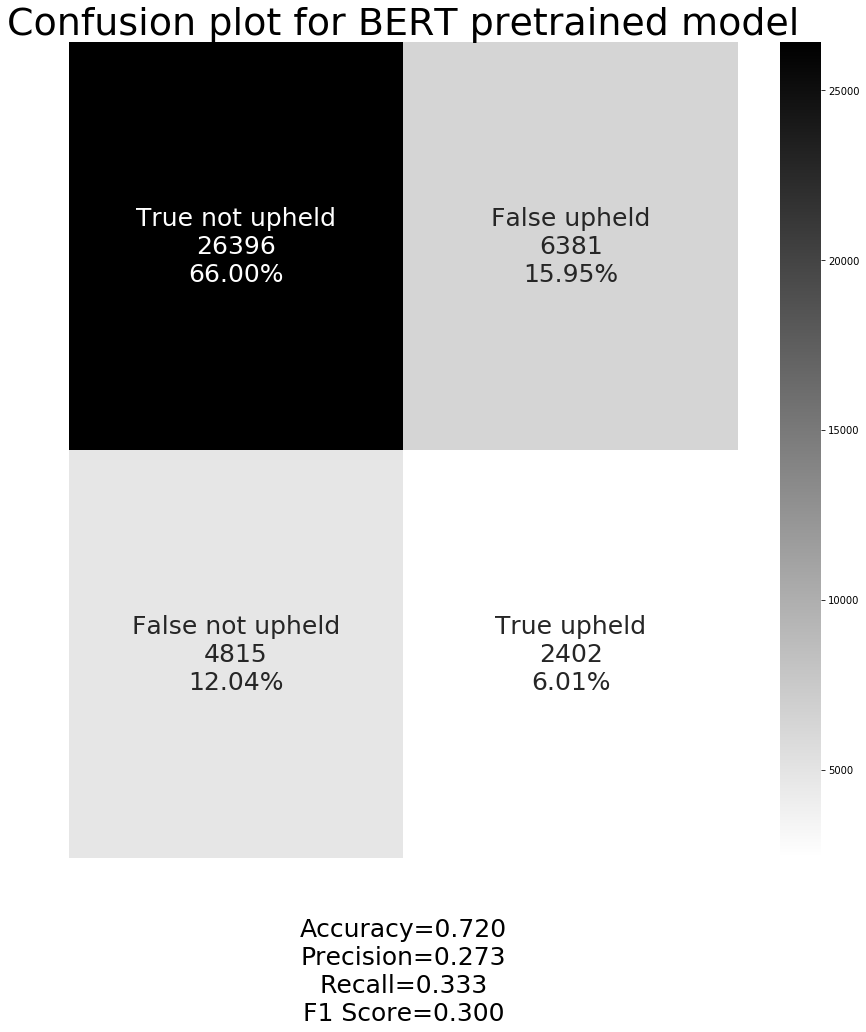

In [49]:
predictions = np.argmax(preds, axis = 1)
cm = confusion_matrix(y_test, predictions)
labels = ['True not upheld', 'False upheld', 'False not upheld', 'True upheld']
categories = ['Not upheld, Upheld']
make_confusion_matrix(np.array(cm, dtype='float'),
                      group_names=labels,
                      categories=categories,
                      xyticks=False,
                      xyplotlabels=False,
                      cmap='binary',
                      figsize=(15,15),
                      fontsize=25,
                      title='Confusion plot for BERT pretrained model')

# Summary
## Tried Gradient Boosting and Deep learning models
### They both yielded over 30% F1-score on the test set
### Best model was the stacked LSTM with 37% F1-score on the test set
### Tried the state-of-the-art BERT pretrained model in Pytorch
## In the future, I could try LSTM models with BERT pretraining and unsupervised clustering with UMAP based on the BERT pretrained encodings
## To investigate the companies that are most likely to disregard a complaint, one could check the highest percentage of untimely responses by company; or could build a logistic regression model after one-hot encoding all the categorical features and see which company has the most negative coefficient 